In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
#import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

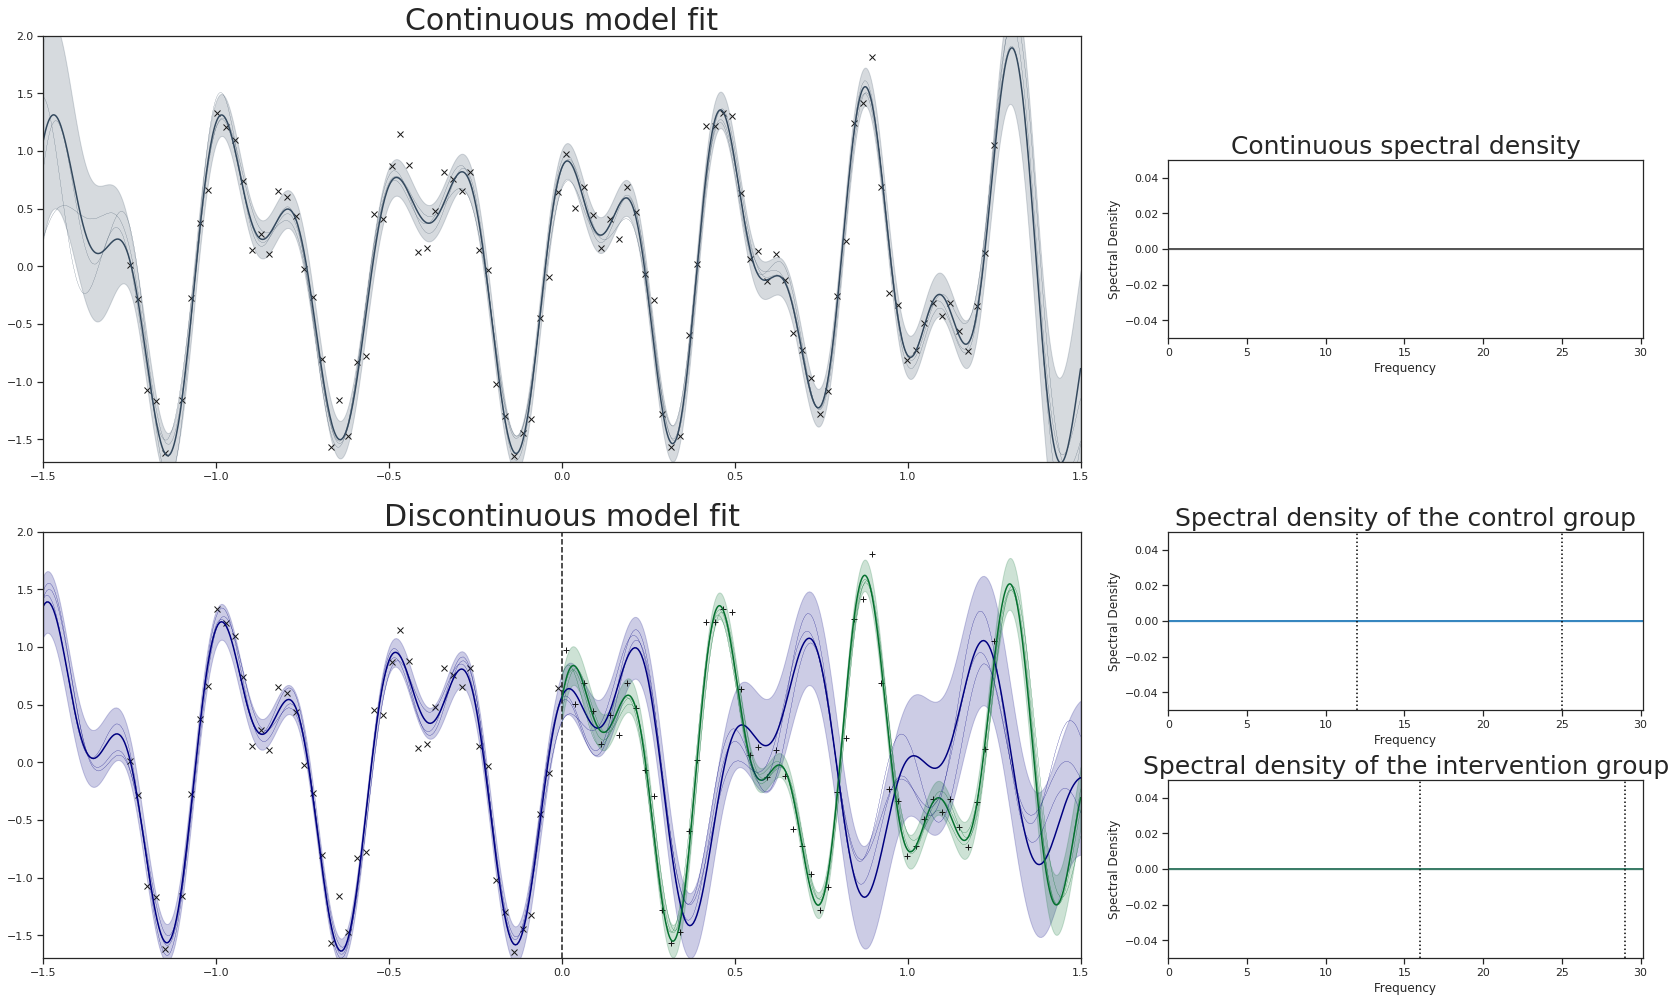



  55.83965102129061 

 3.949411493513292


In [10]:
# Time series fit + spectra 
# ---------------------------

np.random.seed(1)

# Create synthetic data
N           = 100
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
x1, x2      = x[x<=b], x[x>b]
n_seeds     = 1

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
max_freq    = 4 * 2 * np.pi
max_length  = 1.

# Kernels (not used)
colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']
#pt.plot_kernel_spectrum(Q, sm, max_x=max_freq*1.2, title="Initial GMM spectral density", colours=colours_prior)
#plt.show()

# Plotting parameters
padding           = 0.1
ylim              = (-1.7,2.)#(-4.7,5.2)#(-2.5,2.3)

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(2, 9, step=2)
discontinuity_sizes   = np.arange(4, 5, step=2)

discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function)]
                         #,('Amplitude',t.weight_discontinuity_mean_function)]
                         #, ('triple trigonometry', t.triple_trigonometry)]
bayes_factors, effect_sizes_KL, effect_sizes_weight = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(3)]

    
    
# start
for i, d in enumerate(discontinuity_sizes):
      for n, (name, func) in enumerate(discontinuity_funcs):
            for s in range(n_seeds): # repeated trials with different gaussian noise
                np.random.seed(s+4) # s+4: shifting s+6:diverging
                
                # Obtain data with discontinuity
                f = func(x,d)
                y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
                y1, y2            = y[x <= b], y[x > b]

                true_freqs_shifting = [[12 , 25 ], [(12 + d) , (25 + d)] ]
                true_freqs_diverging= [[12 , 25 ], [(12 - d) , (25 + d)] ]
                if name == 'Shifting':
                      true_freqs = true_freqs_shifting
                else:
                      true_freqs = true_freqs_diverging
                #true_freqs = None

                # Create spectral mixture kernel
                Q                 = 2 #t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
                sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

                # Run analysis Spectral Mixture
                a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
                a.train(verbose=False)
                

                log_bayes_factor = a.log_bayes_factor(verbose=False)
                print('\n\nlog bayes factor: ', log_bayes_factor)
                bayes_factors[n,i,s] = log_bayes_factor.numpy()

                t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = max_freq*1.2, 
                                                 true_freqs=true_freqs,ylim=ylim, scalar = 2*np.pi, num_f_samples=3)
                plt.savefig('samplesSyntheticCosDiverging.pdf',dpi=400)
                plt.show()

            
                
    
                # print('Control')
                # for kernel in a.discontinuous_model.models[0].kernel.kernels:
                #       print('Index: ', kernel.index, '. Frequency: ',
                #             round(kernel.frequency.numpy(), 3))
                # print('intervention')
                # for kernel in a.discontinuous_model.models[1].kernel.kernels:
                #       print('Index: ', kernel.index, '. Frequency: ',
                #             round(kernel.frequency.numpy(), 3))

                e_with_weight = t.EffectSizeGMM(a)
                effect_sizes_weight[n,i,s] = e_with_weight
                e_KL = t.EffectSizeGMM(a, mode='KullbackLeibler')
                print('\n\n ', e_KL,'\n\n', e_with_weight)
                effect_sizes_KL[n,i,s] = e_KL


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
L: -2.7719504137337907, k: 14, N: 100
BIC: -35.00814171565043
L: -31.518743079669463, k: 7,

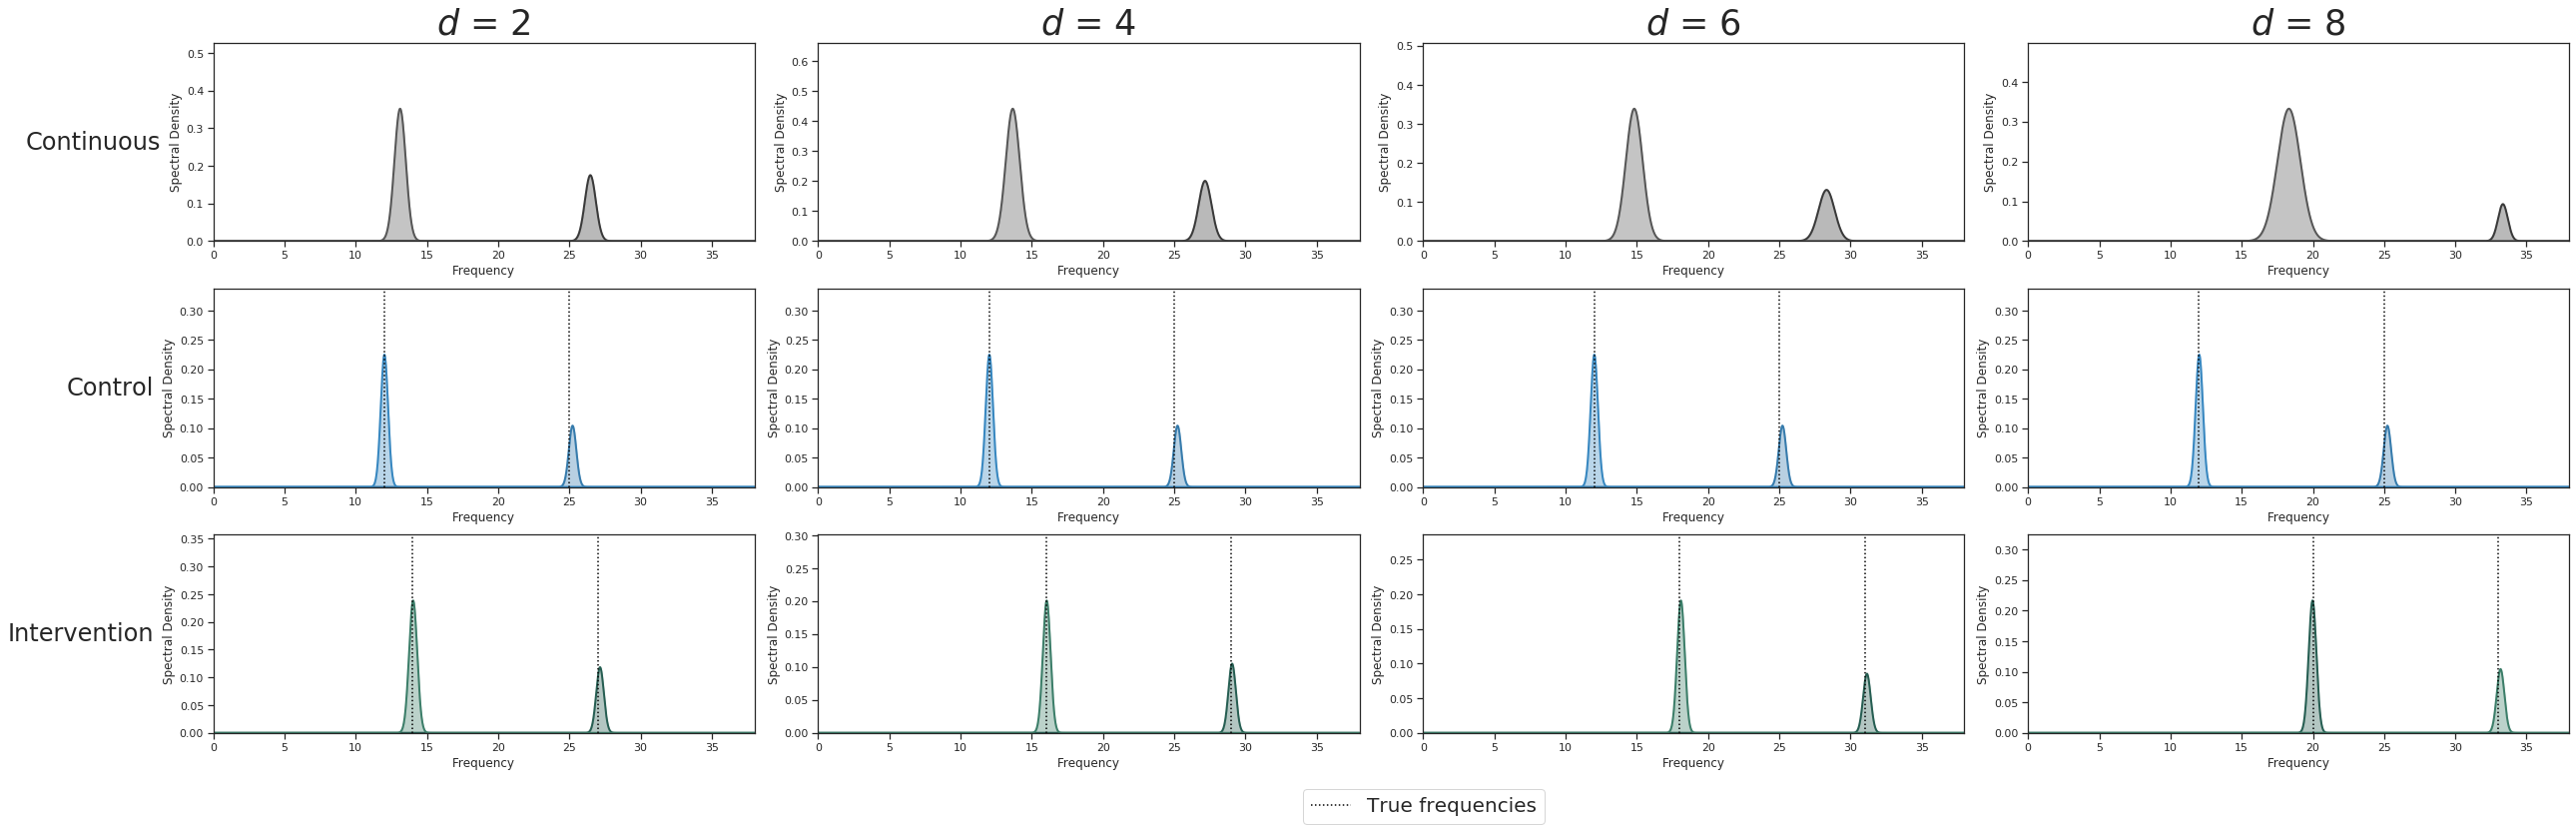

In [3]:
# Plot of only the spectra
np.random.seed(1)

# Create synthetic data
N           = 100
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
x1, x2      = x[x<=b], x[x>b]
n_seeds     = 1

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
max_freq    = 4 * 2 * np.pi
max_length  = 1.

# Kernels (not used)
colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']
#t.plot_kernel_spectrum(Q, sm, max_x=max_freq*1.2, title="Initial GMM spectral density", colours=colours_prior)
#plt.show()

# Plotting parameters
padding           = 0.1
ylim              = (-1.7,2.)#(-4.7,5.2)#(-2.5,2.3)

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(2, 9, step=2)

discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function)]
                         #,('Amplitude',t.weight_discontinuity_mean_function)]
                         #, ('triple trigonometry', t.triple_trigonometry)]
bayes_factors, effect_sizes_KL, effect_sizes_weight = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(3)]

    
    # Continuous spectral GMM    
fig, axes = plt.subplots(3,4,sharex=False,sharey=False,figsize=(9*4,12))
cols = [f'$d$ = {d}'.format(d) for d in discontinuity_sizes]
rows = ['{}'.format(row) for row in ['Continuous','Control', 'Intervention']]
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.02), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=35, ha='center', va='baseline')
   
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=24, ha='right', va='center')
    
# start
for i, d in enumerate(discontinuity_sizes):
      for n, (name, func) in enumerate(discontinuity_funcs):
            for s in range(n_seeds): # repeated trials with different gaussian noise
                np.random.seed(s+4) # s+4: shifting s+6:diverging
                
                # Obtain data with discontinuity
                f = func(x,d)
                y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
                y1, y2            = y[x <= b], y[x > b]

                true_freqs_shifting = [[12 , 25 ], [(12 + d) , (25 + d)] ]
                true_freqs_diverging= [[12 , 25 ], [(12 - d) , (25 + d)] ]
                if name == 'Shifting':
                      true_freqs = true_freqs_shifting
                else:
                      true_freqs = true_freqs_diverging
                #true_freqs = None

                # Create spectral mixture kernel
                Q                 = 2 #t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
                sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

                # Run analysis Spectral Mixture
                a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
                a.train(verbose=False)
                

                log_bayes_factor = a.log_bayes_factor(verbose=False)
                print('\n\nlog bayes factor: ', log_bayes_factor)
                bayes_factors[n,i,s] = log_bayes_factor.numpy()

                t.plot_model_spectra(a,Q,d,axes[:,i] ,index=i, padding=padding, max_x = 38, 
                                        true_freqs=true_freqs,ylim=ylim, scalar = 1)
            
                # print('Control')
                # for kernel in a.discontinuous_model.models[0].kernel.kernels:
                #       print('Index: ', kernel.index, '. Frequency: ',
                #             round(kernel.frequency.numpy(), 3))
                # print('intervention')
                # for kernel in a.discontinuous_model.models[1].kernel.kernels:
                #       print('Index: ', kernel.index, '. Frequency: ',
                #             round(kernel.frequency.numpy(), 3))

                e_with_weight = t.EffectSizeGMM(a)
                effect_sizes_weight[n,i,s] = e_with_weight
                e_KL = t.EffectSizeGMM(a, mode='KullbackLeibler')
                print('\n\n ', e_KL,'\n\n', e_with_weight)
                effect_sizes_KL[n,i,s] = e_KL
fig.tight_layout()
fig.subplots_adjust(top=0.9)    
handles, labels = axes[1,1].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', ncol=1, fontsize=20, fancybox=True,bbox_to_anchor=(0.55, -0.01))
fig.subplots_adjust(bottom=0.1)   
# plt.savefig('shifting_spectra_08.pdf',dpi=100)
# #plt.savefig('diverging_spectra_08-2.pdf',dpi=100)

plt.show()

(1, 4, 1)  : (discontinuity function, discontinuity size, seeds)
(1, 4, 1)  : (discontinuity function, discontinuity size, seeds)


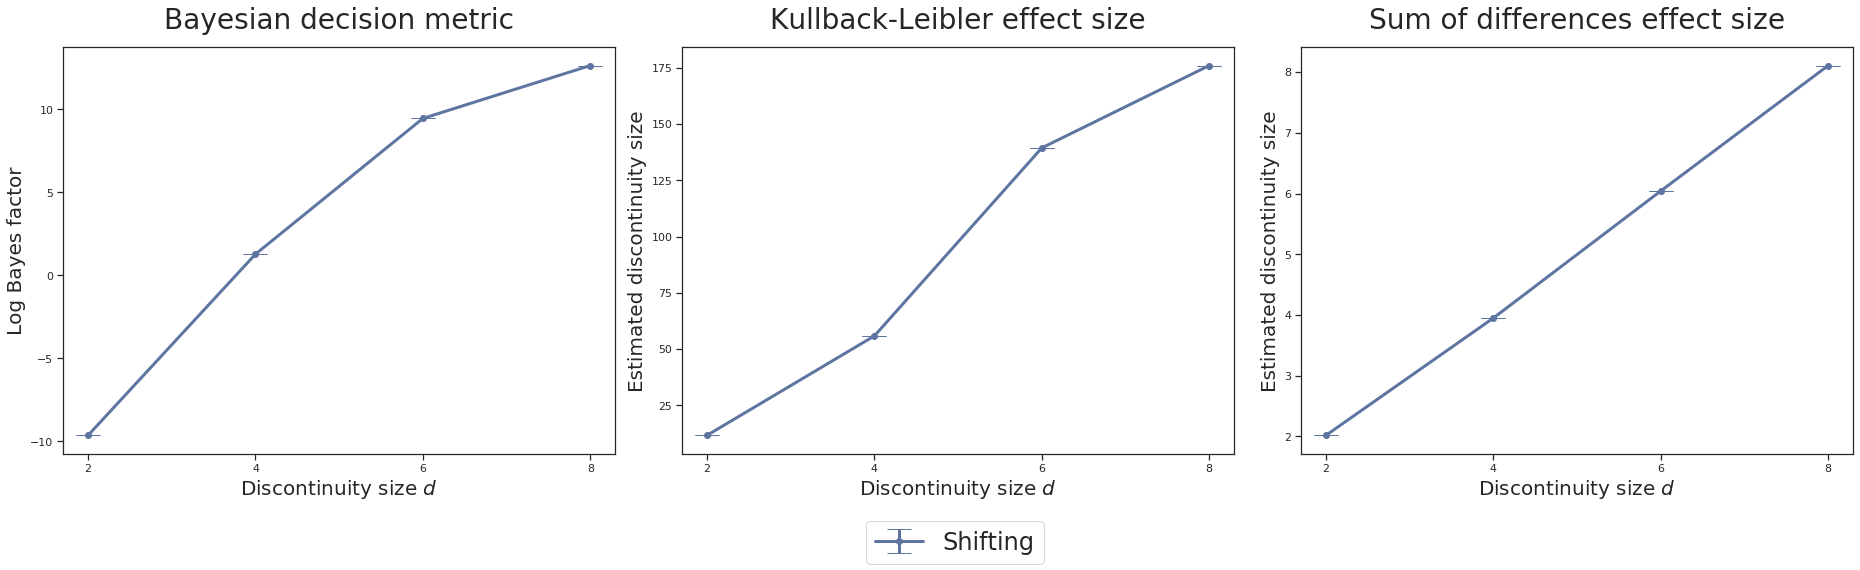

In [4]:
# Bar plot of Effect sizes and Bayes factor
#------------------------

# Set plotting parameters
plt.rc('axes', titlesize=26)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=28)  # fontsize of the figure title
# subfigure title: 24
cs = 12
lw = 3
# Initlaize sibfigure
colors=['#79b895' ,'#374e70', 'purple']
#colors=['green', 'blue']
colors = ['#5e75a1', '#2c9553', 'purple']
sns.set(style="ticks")
fig, ax = plt.subplots(1, 3,figsize=(26,8),sharex=True)

# Bayes factor plot
print(bayes_factors.shape,' : (discontinuity function, discontinuity size, seeds)')

for i, (name, function) in enumerate(discontinuity_funcs):
    disc_mean, disc_std = [np.zeros((discontinuity_sizes.shape[0])) for i in range(2)]
    for j, d in enumerate(discontinuity_sizes):
        disc_mean[j] = np.mean(bayes_factors[i,j,:],axis=0)
        disc_std[j] = np.std(bayes_factors[i,j,:], axis=0)
    ax[0].errorbar(discontinuity_sizes, disc_mean,yerr = disc_std, label=name,color=colors[i],
                  linestyle='-', linewidth=lw,  marker='o',capsize=cs)

ax[0].set_xlabel("Discontinuity size $d$",size=20)
ax[0].set_ylabel("Log Bayes factor",size=20)
ax[0].set_title("Bayesian decision metric", size=28, y=1.03)
ax[0].set_xticks(discontinuity_sizes)
#plt.yticks(np.arange(-20,15,5))

# KL divergence plot
print(effect_sizes_KL.shape,' : (discontinuity function, discontinuity size, seeds)')
for i, (name, function) in enumerate(discontinuity_funcs):
    kl_mean, kl_std = [np.zeros((discontinuity_sizes.shape[0])) for i in range(2)]
    for j, d in enumerate(discontinuity_sizes):
        kl_mean[j] = np.mean((effect_sizes_KL[i,j,:]),axis=0)
        kl_std[j] = np.std((effect_sizes_KL[i,j,:]), axis=0)
    ax[1].errorbar(discontinuity_sizes, kl_mean,yerr = kl_std, label=name,color=colors[i],
                    linestyle='-', linewidth=lw,  marker='o',capsize=cs)

ax[1].set_xlabel("Discontinuity size $d$",size=20)
ax[1].set_ylabel("Estimated discontinuity size",size=20)
ax[1].set_title("Kullback-Leibler effect size", size=28, y = 1.03)
ax[1].set_xticks(discontinuity_sizes)
#plt.yticks(np.arange(-20,15,5))


# Absolute difference
for i, (name, function) in enumerate(discontinuity_funcs):
    es_mean, es_std = [np.zeros((discontinuity_sizes.shape[0])) for i in range(2)]
    for j, d in enumerate(discontinuity_sizes):
        es_mean[j] = np.mean(effect_sizes_weight[i,j,:],axis=0)
        es_std[j] = np.std(effect_sizes_weight[i,j,:], axis=0)
    ax[2].errorbar(discontinuity_sizes, es_mean,yerr = es_std, label=name,color=colors[i],
                  linestyle='-', linewidth=lw,  marker='o',capsize=cs)

ax[2].set_xlabel("Discontinuity size $d$",size=20)
ax[2].set_ylabel("Estimated discontinuity size",size=20)
ax[2].set_title("Sum of differences effect size",size=28, y=1.03)
ax[2].set_xticks(discontinuity_sizes)
#plt.yticks(np.arange(-20,15,5))
handles, labels = ax[2].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', ncol=2, fontsize=24, fancybox=True,bbox_to_anchor=(0.51, -0.01))
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)   
#plt.savefig('effectsizes100runs5july.pdf')
plt.show()


In [5]:
# # 5 Cosines without discontinuity (very likely deprecated, will be removed soon)
# #-------------------------

# # Create synthetic data
# N           = 500
# sigma       = .2
# b           = 0.
# d           = 3.
# x           = np.linspace(-1.25, 1.25, N)
# # remove center data for testing
# remove_center_data = False
# if remove_center_data:
#     empty       = x[40:60]
#     N           = N - len(empty)
#     x           = np.delete(x, np.arange(40,60))
# # end testing

# f           = t.triple_trigonometry(x, d)
# f           = t.diverging_discontinuity_mean_function(x, d)
# y           = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)


# # Generate test points for prediction
# xlim        = [-1.5,1.5]
# xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# mu          = t.shifting_discontinuity_mean_function(xx, d)
# mu          = t.diverging_discontinuity_mean_function(xx, d)
# mu          = t.triple_trigonometry(xx, d)

# true_freqs  = [ [12/(2*np.pi), 25/(2*np.pi)], [(12+d)/(2*np.pi), (25+d)/(2*np.pi)] ]
# #pt.plot_data(x, y, xx, mu, b=b)

# # Data used by the control model and intervention model
# x1, x2      = x[x <= b], x[x>b]
# y1, y2      = y[x <= b], y[x>b]
# xx1, xx2    = xx[xx <= b], xx[xx > b]
# data        = [(x1, y1), (x2, y2)]
# max_freq    = 5. * 2 * np.pi
# max_length  = 1.

# # Kernels

# colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']
# #pt.plot_kernel_spectrum(Q, sm, max_x=max_freq*1.2, title="Initial GMM spectral density", colours=colours_prior)
# #plt.show()

# # Define training parameters
# # Plotting parameters
# padding           = 0.0
# ylim              = (-4.7,5.2)#(-2.5,2.3)

# # Iterate over discontinuity sizes
# discontinuity_sizes   = np.arange(0, 10, step=1)
# discontinuity_sizes   = np.arange(0, 1 , step=1)
# discontinuity_funcs   = [ ('triple trigonometry', t.triple_trigonometry)]#[('diverging',t.diverging_discontinuity_mean_function)
#                          #,('shifting',t.shifting_discontinuity_mean_function)]
#                          #,('weight',t.weight_discontinuity_mean_function)]
                         
# bayes_factors, effect_sizes = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0])) for i in range(2)]
# effect_sizes_with_weights = np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0]))
# effect_sizes_KL = np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0]))

# for i, d in enumerate(discontinuity_sizes):
#       for n, (name, func) in enumerate(discontinuity_funcs):
#             # Obtain data with discontinuity
#             f = func(x,d)
#             y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
#             y1, y2            = y[x <= b], y[x > b]

#             true_freqs_shifting = [[12 / (2 * np.pi), 25 / (2 * np.pi)], [(12 + d) / (2 * np.pi), (25 + d) / (2 * np.pi)]]
#             true_freqs_diverging= [[12 / (2 * np.pi), 25 / (2 * np.pi)], [(12 - d) / (2 * np.pi), (25 + d) / (2 * np.pi)]]
#             if name == 'shifting':
#                   true_freqs = true_freqs_shifting
#             else:
#                   true_freqs = true_freqs_diverging
#             true_freqs = None

#             # Create spectral mixture kernel
#             Q                 = 5 #t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
#             sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

#             # Run analysis Spectral Mixture
#             a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
#             a.train(verbose=False)

#             log_bayes_factor = a.log_bayes_factor(verbose=False)
#             print('Log Bayes factor: ',log_bayes_factor.numpy())
#             #print('Discontinuity: ', d, '. Log bayes factor of: f(x) = sin((12+d)x)+0.66 cos((25+d)x)', log_bayes_factor.numpy())
#             bayes_factors[n,i] = log_bayes_factor.numpy()

#             t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = max_freq*1.*2*np.pi, true_freqs=true_freqs,ylim=ylim, scalar = 2*np.pi)
#             #plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/Counterfactual plots/modelcomparison.png')
#             plt.show()
            
#             # print('Control')
#             # for kernel in a.discontinuous_model.models[0].kernel.kernels:
#             #       print('Index: ', kernel.index, '. Frequency: ',
#             #             round(kernel.frequency.numpy(), 3))
#             # print('intervention')
#             # for kernel in a.discontinuous_model.models[1].kernel.kernels:
#             #       print('Index: ', kernel.index, '. Frequency: ',
#             #             round(kernel.frequency.numpy(), 3))
#             e = t.EffectSizeGMM(a, mode='difference in means')
#             effect_sizes[n,i] = e
#             e_with_weight = t.EffectSizeGMM(a, mode='means and weights')
#             effect_sizes_with_weights[n,i] = e_with_weight
#             e_KL = t.EffectSizeGMM(a, mode='KullbackLeibler')
#             effect_sizes_KL[n,i] = e_KL
#             print('Discontinuity', d,'Effect size', e)

# plot_bayes_factors = False
# if plot_bayes_factors:
#     sns.set(style="ticks")
#     print(bayes_factors)
#     plt.figure()
#     for i, (name, function) in enumerate(discontinuity_funcs):
#         plt.plot(discontinuity_sizes, bayes_factors[i], label=name)
#     plt.xlabel("Discontinuity size d")
#     plt.title("Bayes' factors of f(x)= sin(12x) + cos(25x) ")
#     plt.legend()
#     plt.show()

# plot_effect_sizes = False
# if plot_effect_sizes:
#     # Difference in means
#     sns.set(style="ticks")
#     plt.figure()
#     for i, (name, function) in enumerate(discontinuity_funcs):
#         plt.plot(discontinuity_sizes, effect_sizes[i], label=name)
#     plt.xlabel("Discontinuity size d")
#     plt.title("Effect sizes with difference in means")
#     plt.legend()
#     plt.show()

#     # Means and weights
#     sns.set(style="ticks")
#     plt.figure()
#     for i, (name, function) in enumerate(discontinuity_funcs):
#         plt.plot(discontinuity_sizes, effect_sizes_with_weights[i], label=name)
#     plt.xlabel("Discontinuity size d")
#     plt.title("Effect sizes with difference in means plus difference in weights")
#     plt.legend()
#     plt.show()

#     # Symmetric Kullback-Leibler
#     sns.set(style="ticks")
#     plt.figure()
#     for i, (name, function) in enumerate(discontinuity_funcs):
#         plt.plot(discontinuity_sizes, effect_sizes_KL[i], label=name)
#     plt.xlabel("Discontinuity size d")
#     plt.title("Effect sizes of sum of Kullback Leibler divergence")
#     plt.legend()
#     plt.show()

